In [16]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import Data_Process as dp
from sklearn.model_selection import train_test_split
import Model_LSTM as mlstm

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import Constants



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: module 'numpy' has no attribute 'ndarray'

In [15]:
!conda uninstall -y numpy
!conda uninstall -y setuptools
!conda install setuptools
!conda install numpy

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/osx-64::python==3.9.7=h1248fe1_3_cpython
  - conda-forge/noarch::async_generator==1.10=py_0
  - conda-forge/noarch::attrs==21.2.0=pyhd8ed1ab_0
  - conda-forge/noarch::backcall==0.2.0=pyh9f0ad1d_0
  - conda-forge/noarch::backports==1.0=py_2
  - defaults/osx-64::certifi==2021.10.8=py39hecd8cb5_0
  - conda-forge/noarch::decorator==5.1.0=pyhd8ed1ab_0
  - conda-forge/noarch::defusedxml==0.7.1=pyhd8ed1ab_0
  - conda-forge/noarch::entrypoints==0.3=pyhd8ed1ab_1003
  - conda-forge/noarch::idna==2.10=pyh9f0ad1d_0
  - conda-forge/noarch::ipython_genutils==0.2.0=py_1
  - conda-forge/noarch::joblib==1.0.1=pyhd8ed1ab_0
  - conda-forge/noarch::json5==0.9.5=pyh9f0ad1d_0
  - conda-forge/noarch::nest-asyncio==1.5.1=pyhd8ed1ab_0
  - conda-forge/noarch::pandocfilters==1

In [ ]:
info = pd.read_csv("g-research-crypto-forecasting/asset_details.csv")
ctrain = pd.read_csv("g-research-crypto-forecasting/train.csv")

In [9]:
DEBUG = Constants.DEBUG
EPOCHS = Constants.EPOCHS
N_ASSETS = Constants.N_ASSETS
WINDOW_SIZE = Constants.WINDOW_SIZE
BATCH_SIZE = Constants.BATCH_SIZE
PCT_VALIDATION = Constants.PCT_VALIDATION # last 10% of the data are used as validation set

In [10]:
#take just btc
ctrain_processed = dp.process_all_assets(ctrain)

In [69]:
#train mini data
n_steps_to_train = 360*24*60-4 #0.5 year
ctrain_processed_mini =  ctrain_processed[-n_steps_to_train:]

In [70]:
ctrain_processed_mini.head()

ValueError: Only callable can be used as callback

ValueError: Only callable can be used as callback

In [13]:
ctrain_processed_mini = dp.vwap_change(ctrain_processed_mini)

In [14]:
#scale
from sklearn.preprocessing import RobustScaler

ctrain_processed2_mini = dp.feature_eng(ctrain_processed_mini, row=False)

RS = RobustScaler()
ctrain_processed2_mini_scaled = ctrain_processed2_mini.copy()
ctrain_processed2_mini_scaled[ctrain_processed2_mini_scaled.columns] = RS.fit_transform(ctrain_processed2_mini_scaled)

In [15]:
ctrain_processed2_mini_scaled['Target'].to_numpy().reshape(-1, N_ASSETS)

array([[-0.48159682,  0.06865989, -0.43177344, ...,  0.51201569,
        -0.98825813,  0.49303386],
       [-0.36203666,  0.041241  , -0.02885359, ...,  0.3926843 ,
        -1.41002525,  0.51203353],
       [-0.15683712,  0.30525287,  0.10840991, ...,  1.00247644,
        -1.44857576,  0.40351645],
       ...,
       [ 3.26618297,  1.06338589, -0.1619927 , ...,  1.00314601,
         0.19372873,  1.61243661],
       [ 3.26618297,  1.06338589, -0.1619927 , ...,  1.00314601,
         0.19372873,  1.61243661],
       [ 3.26618297,  1.06338589, -0.1619927 , ...,  1.00314601,
         0.19372873,  1.61243661]])

In [16]:
#reshape for model
import numpy as np
targets = ctrain_processed2_mini_scaled['Target'].to_numpy().reshape(-1, N_ASSETS)
train_data = ctrain_processed2_mini_scaled.values.reshape(-1, N_ASSETS, ctrain_processed2_mini_scaled.shape[1])


In [17]:
X_train, X_test = train_data[:-len(train_data)//PCT_VALIDATION], train_data[-len(train_data)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train_data)//PCT_VALIDATION], targets[-len(train_data)//PCT_VALIDATION:]

In [46]:
train_generator = mlstm.sample_generator(X_train, y_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = mlstm.sample_generator(X_test, y_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
print(f'Sample shape: {train_gen[0][0].shape}')
print(f'Target shape: {train_gen[0][1].shape}')

Sample shape: (1024, 15, 14, 12)
Target shape: (1024, 14)


In [63]:
model = mlstm.get_modell(X_train, y_train)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 15, 14, 12)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_18 (Lambda)             (None, 15, 12)       0           ['input_6[0][0]']                
                                                                                                  
 lambda_19 (Lambda)             (None, 15, 12)       0           ['input_6[0][0]']                
                                                                                                  
 lambda_20 (Lambda)             (None, 15, 12)       0           ['input_6[0][0]']          

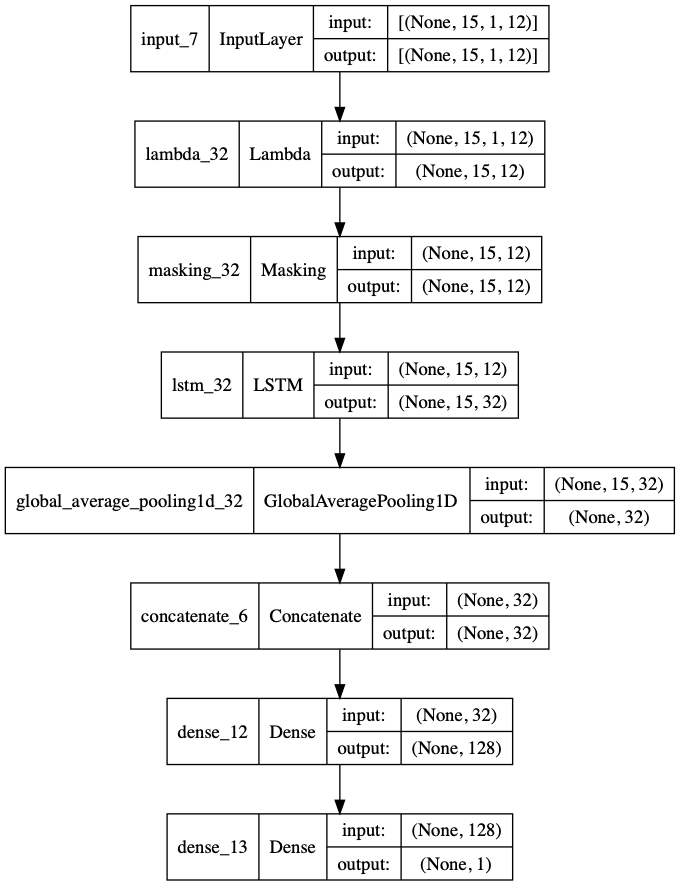

In [64]:
tf.keras.utils.plot_model(mlstm.get_modell(X_train, y_train,n_assets=1), show_shapes=True)

In [65]:
tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [66]:
history = model.fit(train_generator, validation_data=(val_generator), epochs=EPOCHS, callbacks=[lr, estop])


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/10
17/17 [==============================] - 62s 1s/step - loss: 0.0232 - Correlation: -0.0225 - val_loss: 0.0649 - val_Correlation: -0.0621 - lr: 0.0010

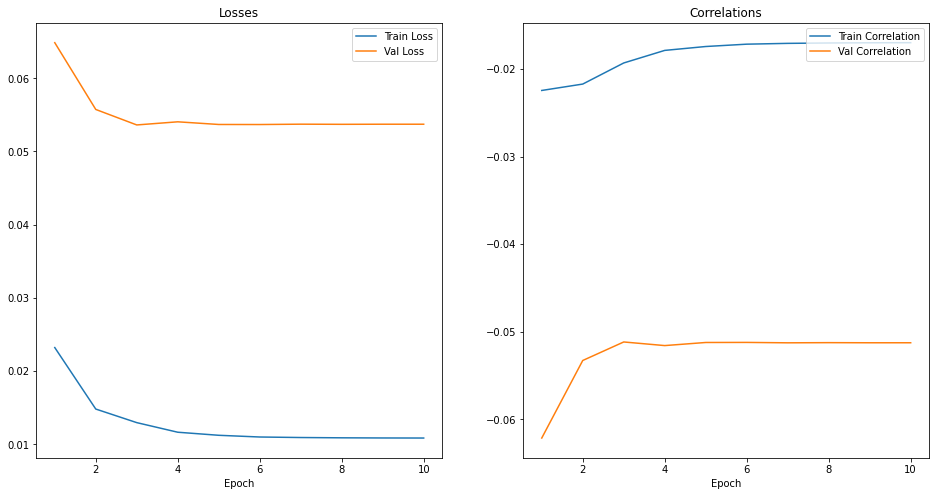

In [67]:
mlstm.plot_training_history(history)

In [68]:
predictions = model.predict(val_generator)
mlstm.prediction_details(predictions=predictions, y_test=y_test, asset_details=asset_details, assets=range(N_ASSETS))

NameError: name 'asset_details' is not defined